# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline



### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Using this information to cluster the general population into groups with similar demographic properties. The people in the customers dataset fit into those created clusters. 

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[-1,XX]      1
[XX]         1
Name: missing_or_unknown, dtype: int64

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. Making cleaning decisions during this stage of the project. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object.

In [6]:
azdias.isnull().sum().sum()

4896838

In [7]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,0,9]     1
[-1,XX]      1
[XX]         1
Name: missing_or_unknown, dtype: int64

In [8]:
#labeling data NaN in azdias if feat_info indicates missing or unknown data.
total_col_numbers = range(len(feat_info))
for col_no in total_col_numbers:
    
    na = feat_info.iloc[col_no]['missing_or_unknown'].strip('[').strip(']').split(sep=',')
    na = [int(i) if (i!='X' and i!='XX' and i!='') else i for i in na]
    if na != ['']:
        azdias = azdias.replace({feat_info.iloc[col_no]['attribute']: na}, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
total = 891220
col_null = azdias.isnull().sum()
col_null = col_null/total*100


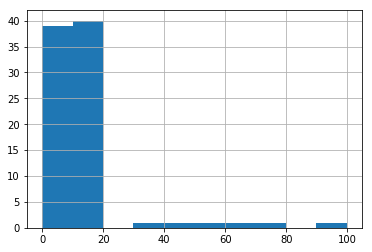

In [10]:
# Investigate patterns in the amount of missing data in each column.
col_null.hist()

In [11]:
# Remove the outlier columns from the dataset. 
col_null = col_null.sort_values(ascending= False)
col_null.head(7)

TITEL_KZ        99.757748
AGER_TYP        76.955522
KK_KUNDENTYP    65.596822
KBA05_BAUMAX    53.468728
GEBURTSJAHR     44.020332
ALTER_HH        34.813738
REGIOTYP        17.735688
dtype: float64

In [12]:
# Remove all columns in the above list except REGIOTYP (17.7% missing only)
drop_cols = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
azdias.drop(drop_cols, inplace = True, axis = 1)

In [13]:
azdias.shape

(891221, 79)

In [14]:
feat_info.set_index('attribute', inplace = True)
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [15]:
drop_rows = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
feat_info.drop(drop_rows, inplace=True, axis =0)

#### Discussion 1.1.2: Assess Missing Data in Each Column

We remove columns with high percentage of missing values. 
We remove columns with missing value percentage above 30%. This included the following:
'TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH'
We also remove the same (rows) from the feat_info dataframe. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. As with the columns, we should see some groups of points that have a very different numbers of missing values. We will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

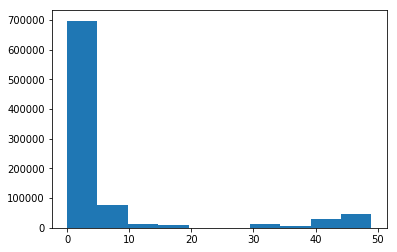

In [16]:
# How much data is missing in each row of the dataset?
row_null = azdias.isnull().sum(axis = 1)
plt.hist(row_null)


In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
more_missing = azdias[row_null>30]
less_missing = azdias[row_null<=30]


In [18]:
# All columns with no missing data 
col_null.tail(24)

FINANZTYP                0.0
GREEN_AVANTGARDE         0.0
FINANZ_HAUSBAUER         0.0
FINANZ_UNAUFFAELLIGER    0.0
FINANZ_ANLEGER           0.0
FINANZ_SPARER            0.0
FINANZ_MINIMALIST        0.0
ANREDE_KZ                0.0
FINANZ_VORSORGER         0.0
SEMIO_FAM                0.0
SEMIO_SOZ                0.0
SEMIO_REL                0.0
SEMIO_MAT                0.0
SEMIO_VERT               0.0
SEMIO_LUST               0.0
SEMIO_ERL                0.0
SEMIO_KULT               0.0
SEMIO_RAT                0.0
SEMIO_KRIT               0.0
SEMIO_DOM                0.0
SEMIO_KAEM               0.0
SEMIO_PFLICHT            0.0
SEMIO_TRADV              0.0
ZABEOTYP                 0.0
dtype: float64

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_columns(col_name):
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many Missing rows')
    sns.countplot(azdias.loc[more_missing.index,col_name])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing rows')
    sns.countplot(azdias.loc[less_missing.index,col_name]);

    plt.show()


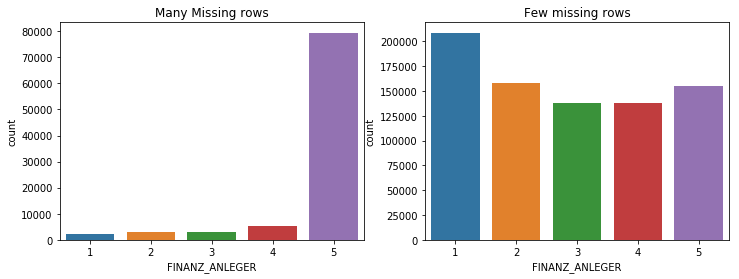

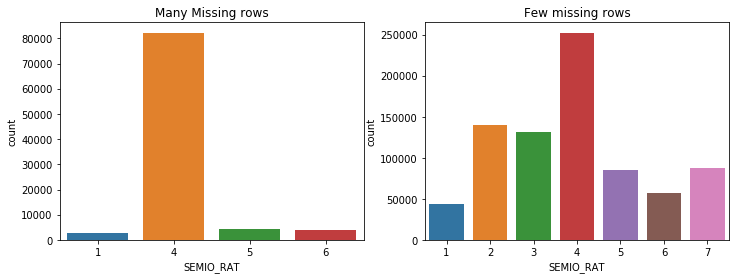

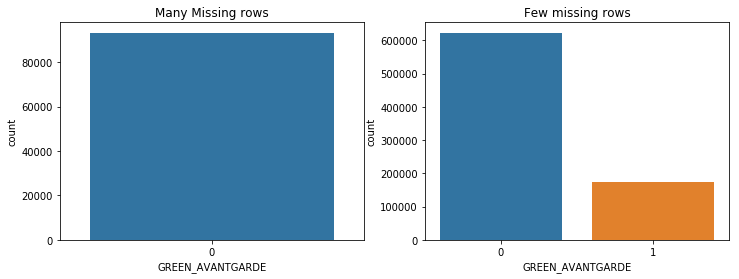

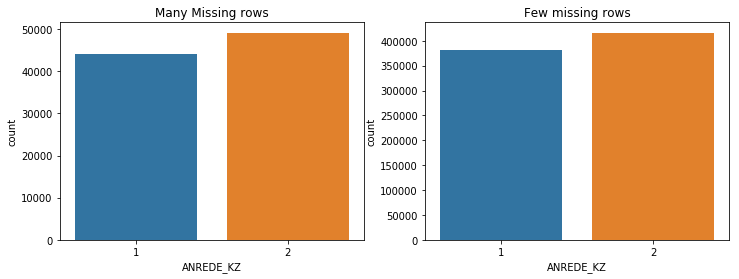

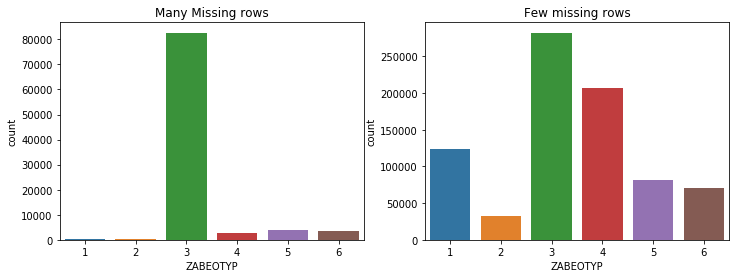

In [20]:
cols = ['FINANZ_ANLEGER','SEMIO_RAT', 'GREEN_AVANTGARDE', 'ANREDE_KZ','ZABEOTYP']
for i in cols:
    compare_columns(i)

#### Discussion 1.1.3: Assess Missing Data in Each Row
There are rows with more than 30 missing values.
Threshold for this problem is chosen as 30. Moving forward, we will only consider the dataframe with less than 30 missing values in a single row. 
There is a big difference in the financial typology for missing and non missing records(FINANZ_ANLEGER). There are similarities in personality typology (SEMIO RAT) and energy consumption (ZABEOTYP). But it seems evident that we lack number of records in many missing rows records. In case of ZABEOTYP, smart(3) consumption is definitely the maximum in both cases. But fair supplied (4) is also prominent in few missing records, while insignificant in many missing records. Similary this can be observed in personality typology (SEMIO RAT). 
There are no memebers of Green Avantgrade in missing records. 
The gender seems to be very consistent among both the dataframes irrespective of missing rows. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [21]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorial_features = feat_info[feat_info.type=='categorical']

binary_cat = []
multi_cat = []
for col in categorial_features.index.values:
    if less_missing[col].nunique() == 2:
        binary_cat.append(col)
    elif less_missing[col].nunique() > 2:
        multi_cat.append(col)
    else:
        print('ERROR')

In [23]:
for col in binary_cat:
    print(col, less_missing[col].value_counts())

ANREDE_KZ 2    416181
1    381886
Name: ANREDE_KZ, dtype: int64
GREEN_AVANTGARDE 0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
SOHO_KZ 0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
VERS_TYP 2.0    394238
1.0    367103
Name: VERS_TYP, dtype: int64
OST_WEST_KZ W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64


In [24]:
# Encoding to 0 and 1 for binary
less_missing['ANREDE_KZ'].replace([2,1],[1,0],inplace=True)
#less_missing['SOHO_KZ'].replace([0.0,1.0],[0,1],inplace=True)
less_missing['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)
less_missing['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [25]:
for col in binary_cat:
    print(col, less_missing[col].value_counts())

ANREDE_KZ 1    416181
0    381886
Name: ANREDE_KZ, dtype: int64
GREEN_AVANTGARDE 0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
SOHO_KZ 0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
VERS_TYP 1.0    394238
0.0    367103
Name: VERS_TYP, dtype: int64
OST_WEST_KZ 1    629525
0    168542
Name: OST_WEST_KZ, dtype: int64


In [26]:
# For Binary category
less_missing = pd.get_dummies(less_missing, columns=binary_cat)

In [27]:
for col in multi_cat:
    print(col, less_missing[col].value_counts())

CJT_GESAMTTYP 4.0    198296
3.0    147220
2.0    141269
5.0    111114
6.0    102108
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP 6    289061
1    197172
5    106333
2    104774
4     55924
3     44803
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP 12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57132
3.0      53101
1.0      50659
2.0      43858
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
LP_FAMILIE_FEIN 1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB 1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN 1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27592
8.0      18837
7.0       9204
Name: LP_STATUS_FEIN

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
less_missing = pd.get_dummies(less_missing, columns=multi_cat)


In [29]:
less_missing.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

For all binary categorical features such as ANREDE_KZ,VERS_TYP and OST_WEST_KZ re-encode to 0 or 1 for simplicity. Used get_dummies to create one hot encoding for both binary and multilevel categorical features. The multi level categorical features were straight forward, so we kept it in the project to avoid any loss of important information. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variable.


In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
less_missing['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182985
8.0     141630
10.0     85808
5.0      84692
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [31]:
# Dictionary for replacing values
replace_decade = {1.0:1, 2.0:1, 3.0:2, 4.0:2, 5.0:3, 6.0:3, 7.0:3, 8.0:4, 9.0:4, 10.0:5, 11.0:5, 12.0:5, 13.0:5, 14.0:6, 15.0:6}
replace_movement = {1.0:0, 2.0:1, 3.0:0, 4.0:1, 5.0:0, 6.0:1, 7.0:1, 8.0:0, 9.0:1, 10.0:0, 11.0:1, 12.0:0, 13.0:1, 14.0:0, 15.0:1}

In [32]:
# Engineer new features
less_missing['DECADE_PJ'] = less_missing['PRAEGENDE_JUGENDJAHRE']
less_missing['DECADE_PJ'].replace(replace_decade, inplace=True)

In [33]:
less_missing['MOVEMENT_PJ'] = less_missing['PRAEGENDE_JUGENDJAHRE']
less_missing['MOVEMENT_PJ'].replace(replace_movement, inplace=True)

In [34]:
less_missing.DECADE_PJ.value_counts()

6.0    225532
4.0    175200
5.0    151770
3.0    114354
2.0     74296
1.0     28157
Name: DECADE_PJ, dtype: int64

In [35]:
less_missing.MOVEMENT_PJ.value_counts()

0.0    594084
1.0    175225
Name: MOVEMENT_PJ, dtype: int64

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
less_missing['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39627
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [37]:
# Dictionary for replacing values
replace_wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
replace_stage= {'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':3,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}

In [38]:
# Engineer new features
less_missing['WEALTH_CAMEO'] = less_missing['CAMEO_INTL_2015']
less_missing['WEALTH_CAMEO'].replace(replace_wealth, inplace=True)

In [39]:
less_missing['STAGE_CAMEO'] = less_missing['CAMEO_INTL_2015']
less_missing['STAGE_CAMEO'].replace(replace_stage, inplace=True)

In [40]:
less_missing.WEALTH_CAMEO.value_counts()

5.0    223582
2.0    190689
4.0    189960
1.0    119442
3.0     68193
Name: WEALTH_CAMEO, dtype: int64

In [41]:
less_missing.STAGE_CAMEO.value_counts()

1.0    245054
4.0    232777
3.0    119692
5.0    117044
2.0     77299
Name: STAGE_CAMEO, dtype: int64

In [42]:
feat_info[feat_info.type=='mixed']

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [43]:
less_missing.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace=True)


In [44]:
feat_info.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 0, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE is divided into two different features, based on the decade i.e. 50s, 60s etc and movement such as avantgrade or mainstream. Moreover, CAMEO_INTL_2015 is also engineered into wealth (wealthy, prosperous, comfortable, poor households) and life stages (single, young couple, middle aged couple, old) of the person. 
Lastly we get rid of all mixed-type features for simplicity. 

#### Step 1.2.3: Complete Feature Selection

To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.


In [45]:
less_missing.head()


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE_PJ,MOVEMENT_PJ,WEALTH_CAMEO,STAGE_CAMEO
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,0,0,0,0,0,0,6.0,0.0,5.0,1.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,0,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,0,0,0,0,0,0,4.0,0.0,4.0,3.0
5,1.0,3,1,5,2,2,5,3.0,3.0,2,...,0,0,0,0,0,0,2.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

In [47]:
#Function accumulating all cleaning steps done so far
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';') 
    
    total_col_numbers = range(len(feat_info))
    for col_no in total_col_numbers:
        na = feat_info.iloc[col_no]['missing_or_unknown'].strip('[').strip(']').split(sep=',')
        na = [int(i) if (i!='X' and i!='XX' and i!='') else i for i in na]
        if na != ['']:
            df = df.replace({feat_info.iloc[col_no]['attribute']: na}, np.nan)
    
    # remove selected columns and rows, ...
    drop_cols = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df.drop(drop_cols, inplace = True, axis = 1)
    row_null = azdias.isnull().sum(axis = 1)
    #print(df.shape)
    
    df = df[row_null<=30]
    #print(df.shape)
    
    # select, re-encode, and engineer column values.
    feat_info.set_index('attribute', inplace = True)
    drop_rows = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    feat_info.drop(drop_rows, inplace=True)
    
    categorial_features = feat_info[feat_info.type=='categorical']

    binary_cat = []
    multi_cat = []
    for col in categorial_features.index.values:
        if df[col].nunique() == 2:
            binary_cat.append(col)
        elif df[col].nunique() > 2:
            multi_cat.append(col)
    
    df['ANREDE_KZ'].replace([2,1],[1,0],inplace=True)
    df['SOHO_KZ'].replace([0.0,1.0],[0,1],inplace=True)
    df['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)
    df['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)
    
    df = pd.get_dummies(df, columns=binary_cat)
    df = pd.get_dummies(df, columns=multi_cat)

    
    replace_decade = {1.0:1, 2.0:1, 3.0:2, 4.0:2, 5.0:3, 6.0:3, 7.0:3, 8.0:4, 9.0:4, 10.0:5, 11.0:5, 12.0:5, 13.0:5, 14.0:6, 15.0:6}
    replace_movement = {1.0:0, 2.0:1, 3.0:0, 4.0:1, 5.0:0, 6.0:1, 7.0:1, 8.0:0, 9.0:1, 10.0:0, 11.0:1, 12.0:0, 13.0:1, 14.0:0, 15.0:1}
    df['DECADE_PJ'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE_PJ'].replace(replace_decade, inplace=True)
    df['MOVEMENT_PJ'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT_PJ'].replace(replace_movement, inplace=True)
    
    replace_wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,'21':2,'22':2,'23':2,'24':2,'25':2,'31':3,'32':3,'33':3,'34':3,'35':3,'41':4,'42':4,'43':4,'44':4,'45':4,'51':5,'52':5,'53':5,'54':5,'55':5}
    replace_stage= {'11':1,'12':2,'13':3,'14':4,'15':5,'21':1,'22':2,'23':3,'24':4,'25':5,'31':1,'32':2,'33':3,'34':4,'35':5,'41':1,'42':2,'43':3,'44':4,'45':5,'51':1,'52':2,'53':3,'54':4,'55':5}
    df['WEALTH_CAMEO'] = df['CAMEO_INTL_2015']
    df['WEALTH_CAMEO'].replace(replace_wealth, inplace=True)
    df['STAGE_CAMEO'] = df['CAMEO_INTL_2015']
    df['STAGE_CAMEO'].replace(replace_stage, inplace=True)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis = 1, inplace=True)

    
    # Return the cleaned dataframe.
    return df

In [49]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

df_clean = clean_data(azdias)
print(df_clean.head())
print(df_clean.shape)

   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1                   1.0                  1              5                 2   
2                   3.0                  1              4                 1   
3                   4.0                  4              2                 5   
4                   3.0                  4              3                 4   
5                   1.0                  3              1                 5   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1               5                      4                 5         3.0   
2               2                      3                 5         3.0   
3               2                      1                 2         2.0   
4               1                      3                 2         3.0   
5               2                      2                 5         3.0   

   RETOURTYP_BK_S  SEMIO_SOZ     ...       CAMEO_DEU_2015_8D  \
1             1.

In [50]:
# This feature will not be created in the customers dataframe (third part of the project)
# To maintain consistency. 
# Also this feature only has 1 True value. Removing this would not impact this analysis.
df_clean.drop('GEBAEUDETYP_5.0',axis = 1, inplace=True)

In [51]:
df_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE_PJ,MOVEMENT_PJ,WEALTH_CAMEO,STAGE_CAMEO
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,0,0,0,0,0,0,6.0,0.0,5.0,1.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,0,0,0,0,0,0,6.0,1.0,2.0,4.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,0,0,0,0,0,0,4.0,0.0,1.0,2.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,0,0,0,0,0,0,4.0,0.0,4.0,3.0
5,1.0,3,1,5,2,2,5,3.0,3.0,2,...,0,0,0,0,0,0,2.0,0.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

In [52]:
# Check for missing data
df_clean.isnull().sum().value_counts()


0        162
40172      6
23363      6
592        3
4750       2
4227       2
28764      2
64912      2
6200       2
36732      1
12648      1
72         1
59309      1
6463       1
4126       1
3860       1
7          1
2803       1
dtype: int64

In [53]:
# Filling missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent')
df_clean_imputed = imputer.fit_transform(df_clean)

In [54]:
df_clean_imputed

array([[ 1.,  1.,  5., ...,  0.,  5.,  1.],
       [ 3.,  1.,  4., ...,  1.,  2.,  4.],
       [ 4.,  4.,  2., ...,  0.,  1.,  2.],
       ..., 
       [ 2.,  2.,  4., ...,  0.,  2.,  4.],
       [ 1.,  1.,  5., ...,  0.,  5.,  1.],
       [ 4.,  4.,  2., ...,  0.,  4.,  3.]])

In [55]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_clean_scaled = scaler.fit_transform(df_clean_imputed)


In [56]:
df_ready = pd.DataFrame(df_clean_scaled)
df_ready.columns = df_clean.columns
df_ready.shape

(798069, 196)

### Discussion 2.1: Apply Feature Scaling

We used Imputer to fill the most frequent values in place of the missing values. Moreover, we used Standard Scaler for feature scaling the data set.

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, we are now ready to apply dimensionality reduction techniques.

In [57]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca


In [58]:
pca_test, df_pca_test = do_pca(101,df_ready)

In [59]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    



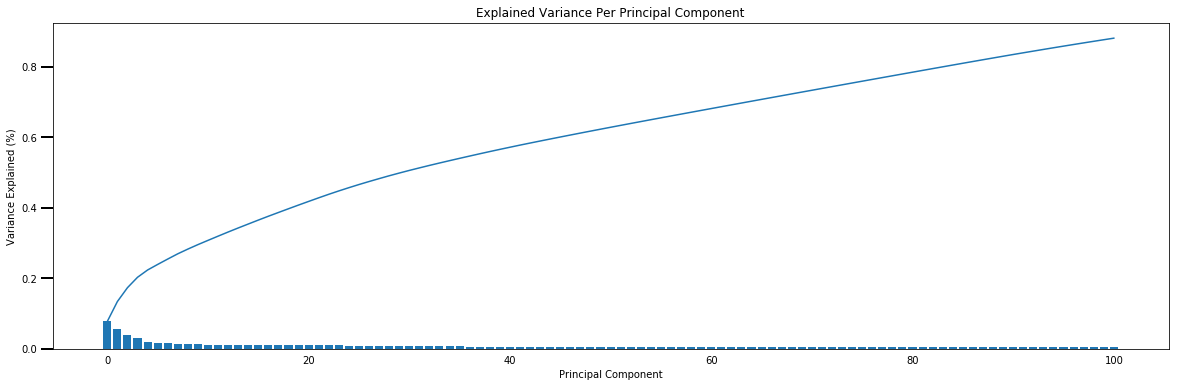

In [61]:
scree_plot(pca_test)


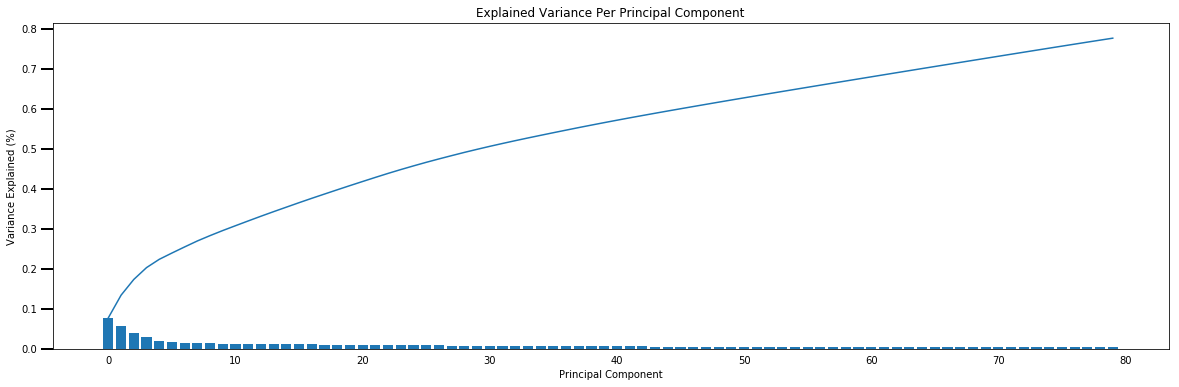

In [77]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, df_pca = do_pca(80,df_ready)
scree_plot(pca)


In [63]:
pca.components_

array([[ -8.62361718e-02,  -1.93943781e-01,   1.18021818e-01, ...,
         -1.14495664e-01,   1.84412499e-01,  -1.10054987e-01],
       [  2.30729636e-01,   8.10832966e-02,  -2.24192322e-01, ...,
         -1.20031149e-02,   6.11055875e-02,   9.88287474e-03],
       [  2.63099362e-02,   1.18730728e-01,  -5.72393714e-02, ...,
          6.34924584e-02,   2.76748210e-02,  -1.79896930e-02],
       ..., 
       [ -1.28074934e-02,  -1.17486743e-03,  -8.55974088e-03, ...,
         -4.45030480e-03,   1.95557402e-03,  -9.09215763e-03],
       [ -4.87536311e-03,   2.16674991e-03,   1.25181133e-04, ...,
         -4.04782519e-02,  -3.94132065e-02,  -9.32593263e-03],
       [  1.17636944e-02,   4.13124044e-03,  -6.61115180e-03, ...,
         -1.81952797e-02,  -3.29123551e-02,   1.07080785e-02]])

### Discussion 2.2: Perform Dimensionality Reduction

Applying PCA to the dataset. On investiating on the 101 features (more than half), we could establish that for 80 components there is 76% of variance explained. This can be visualized from the scree plot. We fit and transform the data set for 80 principle components. 

### Step 2.3: Interpret Principal Components

We transformed principal components, it's a nice idea to check out the weight of each variable on the first few components.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components).

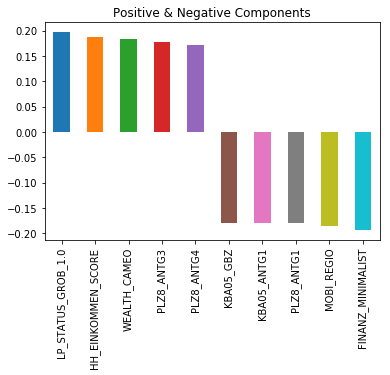

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_pca_ = pd.DataFrame(pca.components_, columns=df_ready.columns)
weights = df_pca_.iloc[0].sort_values(ascending=False)
weights_total = pd.concat([weights.head(),weights.tail()])
weights_total.plot(kind='bar', title='Positive & Negative Components')

In [89]:
weights = df_pca_.iloc[0].sort_values(ascending=False)
print(weights.head())
print(weights.tail())

LP_STATUS_GROB_1.0    0.196769
HH_EINKOMMEN_SCORE    0.188253
WEALTH_CAMEO          0.184412
PLZ8_ANTG3            0.178430
PLZ8_ANTG4            0.172489
Name: 0, dtype: float64
KBA05_GBZ           -0.179928
KBA05_ANTG1         -0.180224
PLZ8_ANTG1          -0.180628
MOBI_REGIO          -0.186815
FINANZ_MINIMALIST   -0.193944
Name: 0, dtype: float64


ALTERSKATEGORIE_GROB    0.230730
FINANZ_VORSORGER        0.216083
ZABEOTYP_3              0.200825
SEMIO_ERL               0.185518
SEMIO_LUST              0.161271
Name: 1, dtype: float64
SEMIO_TRADV             -0.206030
FINANZ_UNAUFFAELLIGER   -0.214419
SEMIO_REL               -0.217520
FINANZ_SPARER           -0.224192
DECADE_PJ               -0.228137
Name: 1, dtype: float64


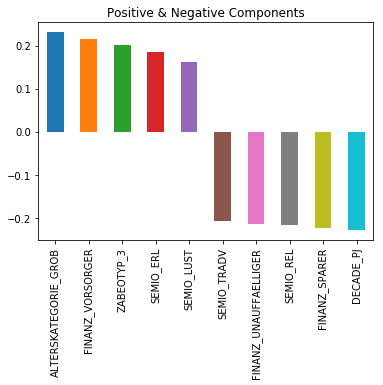

In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = df_pca_.iloc[1].sort_values(ascending=False)
weights_total = pd.concat([weights.head(),weights.tail()])
weights_total.plot(kind='bar', title='Positive & Negative Components')
print(weights.head())
print(weights.tail())

ANREDE_KZ_0    0.330000
SEMIO_VERT     0.301391
SEMIO_FAM      0.241130
SEMIO_SOZ      0.239653
SEMIO_KULT     0.232562
Name: 2, dtype: float64
SEMIO_ERL     -0.188556
SEMIO_KRIT    -0.247058
SEMIO_DOM     -0.266915
SEMIO_KAEM    -0.297286
ANREDE_KZ_1   -0.330000
Name: 2, dtype: float64


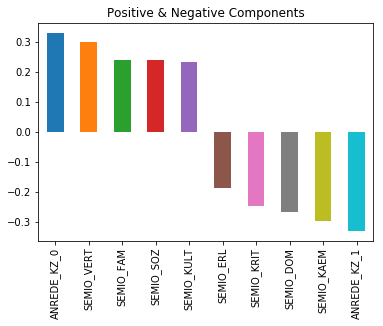

In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights = df_pca_.iloc[2].sort_values(ascending=False)
weights_total = pd.concat([weights.head(),weights.tail()])
weights_total.plot(kind='bar', title='Positive & Negative Components')
print(weights.head())
print(weights.tail())


### Discussion 2.3: Interpret Principal Components

For the first princple component, it can be seen that low income earners(LP_STATUS_GROB_1) has high correlation with estimated household net income(HH_EINKOMMEN_SCORE), and negative correlation with moving patterns(MOBI_REGIO). 
The bar chart gives an idea about which features are correlated positively and negatively. 
Similarly, this can be seen for the second and third components. The bars in the same direction have postive correlation, while negative in opposite direction.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We have assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.


In [82]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans


    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to the data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score



In [83]:
scores = []
centers = list(range(5,18,3))

for center in centers:
    scores.append(get_kmeans_score(df_pca, center))

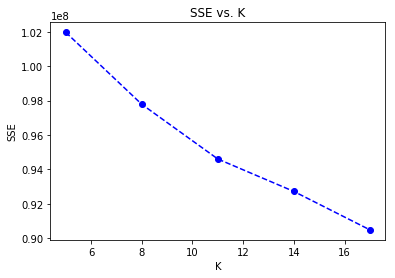

In [84]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [85]:
scores2 = []
centers2 = list(range(20,31,3))

for center in centers2:
    scores2.append(get_kmeans_score(df_pca, center))

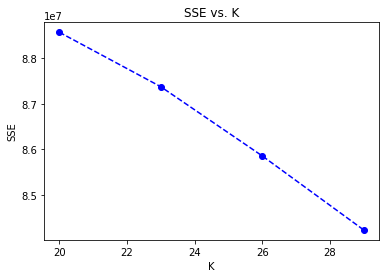

In [86]:
# Investigate the change in within-cluster distance across number of clusters.

plt.plot(centers2, scores2, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [88]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=26)
model = kmeans.fit(df_pca)
predict = model.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population

As the number of clusters increase, we can see the decrease in the value of our score (SSE). On trying different values of number of clusters, unfortunately unable to find the number of cluster where the graph line elbows. Taking 26 as number of clusters, fitting and predicting the data set using KMeans.

Note: This step of finding number of clusters was very slow (takes more than an hour to solve).


### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Instead, we are going to use the fits from the general population to clean, transform, and cluster the customer data. 

In [90]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [91]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [92]:
customers_clean.shape

(171506, 196)

In [93]:
#Imputing and scaling the cleaned customer dataframe
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent')
customer_clean_imputed = imputer.fit_transform(customers_clean)

customer_clean_scaled = scaler.fit_transform(customer_clean_imputed)

customer_ready = pd.DataFrame(customer_clean_scaled)
customer_ready.columns = customers_clean.columns



In [94]:
customer_ready.shape

(171506, 196)

In [95]:
df_ready.shape

(798069, 196)

In [96]:
# Applying PCA for 80 components
customer_pca, customer_X_pca = do_pca(80,customer_ready)

In [97]:
# Cluster predictions for the customer data.
predict_customers = model.fit_predict(customer_X_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

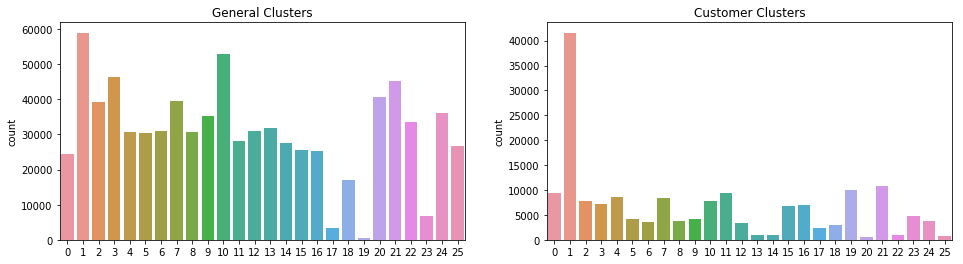

In [98]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax1.title.set_text('General Clusters')
sns.countplot(predict)

ax2 = fig.add_subplot(122)
ax2.title.set_text('Customer Clusters')
sns.countplot(predict_customers)


plt.show()


In [103]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cc = model.cluster_centers_[19]
pca_inv = pca.inverse_transform(cc)
over_rep = scaler.inverse_transform(pca_inv)
df_over = pd.Series(over_rep)
df_over.index = customers_clean.columns

In [104]:
df_over

ALTERSKATEGORIE_GROB     3.402141
FINANZ_MINIMALIST        4.585618
FINANZ_SPARER            1.733934
FINANZ_VORSORGER         4.308176
FINANZ_ANLEGER           2.909038
FINANZ_UNAUFFAELLIGER    1.890032
FINANZ_HAUSBAUER         2.077476
HEALTH_TYP               1.943902
RETOURTYP_BK_S           3.626526
SEMIO_SOZ                3.747876
SEMIO_FAM                4.328971
SEMIO_REL                3.663613
SEMIO_MAT                3.514524
SEMIO_VERT               4.923325
SEMIO_LUST               5.302335
SEMIO_ERL                4.693739
SEMIO_KULT               3.839015
SEMIO_RAT                2.718359
SEMIO_KRIT               4.097111
SEMIO_DOM                3.893188
SEMIO_KAEM               3.631027
SEMIO_PFLICHT            3.137094
SEMIO_TRADV              2.511424
ANZ_PERSONEN             3.522701
ANZ_TITEL               -0.014287
HH_EINKOMMEN_SCORE       2.876200
W_KEIT_KIND_HH           3.009419
WOHNDAUER_2008           9.052464
ANZ_HAUSHALTE_AKTIV      1.777103
ANZ_HH_TITEL  

In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cc = model.cluster_centers_[20]
pca_inv = pca.inverse_transform(cc)
under_rep = scaler.inverse_transform(pca_inv)
df_under = pd.Series(under_rep)
df_under.index = customers_clean.columns

In [106]:
df_under

ALTERSKATEGORIE_GROB     3.848336
FINANZ_MINIMALIST        4.745557
FINANZ_SPARER            2.494267
FINANZ_VORSORGER         4.171455
FINANZ_ANLEGER           2.532528
FINANZ_UNAUFFAELLIGER    3.084994
FINANZ_HAUSBAUER         1.393898
HEALTH_TYP               2.807335
RETOURTYP_BK_S           3.837076
SEMIO_SOZ                4.836555
SEMIO_FAM                4.282913
SEMIO_REL                2.861777
SEMIO_MAT                0.837180
SEMIO_VERT               5.676650
SEMIO_LUST               7.469160
SEMIO_ERL                4.424362
SEMIO_KULT               3.774622
SEMIO_RAT                1.277997
SEMIO_KRIT               3.792733
SEMIO_DOM                3.934472
SEMIO_KAEM               3.355599
SEMIO_PFLICHT            2.193494
SEMIO_TRADV              1.853274
ANZ_PERSONEN             2.387181
ANZ_TITEL                0.031197
HH_EINKOMMEN_SCORE       1.571926
W_KEIT_KIND_HH           3.807033
WOHNDAUER_2008           9.196647
ANZ_HAUSHALTE_AKTIV      1.634854
ANZ_HH_TITEL  

### Discussion 3.3: Compare Customer Data to Demographics Data

From the graph it is evident that cluster 19 is overrepresented in the customer dataset compared to the general population. People typified in Cluster 19 comprise of:
<li> STAGE_CAMEO -> Peoples life stage like pre-family, young couple, old families
<li> WOHNDAUER_2008 -> Peoples length of Residence
<li> RETOURTYP_BK_S -> Peoples return type like demanding, incentive, conservative, determined.
<br>
On the other hand, cluster 20 is underrepresented in the customer dataset compared to the general population. People typified in Cluster 20 comprise of:
<li> ALTERSKATEGORIE_GROB -> Peoples estimated age on given name
<li> SEMIO_ERL -> Event Oriented Personality of people
<li> FINANZ_MINIMALIST -> People with low financial interest 